# Neural Fitted Q (NFQ)

In reinforcement learning, we build agents that are capable of learning from feedback that is simultaneously **evaluative, delayed, and sampled**. 

**Delayed feedback**. Imagine a chess game in which you make a few wrong moves early on, but the consequences only manifest at the end of the game. Delayed feedback makes it tricky to interpret the source of the feedback and rise the **temporal credit assignment problem**: the challenge of determining which state, action, or state-action pair is responsible for a reward. The opposite is **immediate feedback**. In supervised learning decisions don’t have long-term consequences. For example, in a classification problem, classifying an image, whether correctly or not, has no bearing on future performance.

<img src="./images/sequential-feedback.png" width="550">

**Evaluative feedback**: the goodness of the feedback is only relative, because the environment is uncertain. The agent doesn’t know the actual dynamics of the environment (no access to the transition and reward functions). As a result, the agent must explore the environment, but the  problem is that by exploring the agent misses capitalizing on its current knowledge. This is the exploration-exploitation trade-off. The opposite is **supervised feedback**. In a classification problem, during learning, the model is given the correct labels for each of the samples provided: there’s no guessing. 

<img src="./images/evaluative-feedback.png" width="600">

**Sampled feedback**: in real problems, agents are unlikely to sample all possible feedback exhaustively. Agents **need to generalize** using the gathered feedback and come up with intelligent decisions based on that generalization. The opposite is **exhaustive feedback**, where agents have access to all possible samples. Tabular reinforcement learning only needs to sample for long enough to gather all necessary information for optimal performance and they have optimal convergence guarantees. Common assumptions, such as "sampling every state-action pair infinitely often", are reasonable assumptions in small grid worlds with finite state and action spaces, but not in real settings.

<img src="./images/sampled-feedback.png" width="600">

If the feedback is evaluative, delayed and sampled at the same time, the challenge is even more significant. Algorithms must simultaneously balance immediate and long-term goals, the gathering and utilization of information and the need of generalization.

The main drawback of **tabular reinforcement learning** (the methods that we have seen so far) is that the use of a table to represent value functions is **no longer practical in complex problems**. For example, Q-learning estimates the values of the optimal action-value function Q, which is represented by a matrix indexed by states and actions:

<img src="./images/tabular-rl.png" width="600">

In many of the tasks to which we would like to apply reinforcement learning **the state space is combinatorial and enormous**. Environments can have **high-dimensional state spaces** (the number of variables that comprise a single state is vast) or can additionally have **continuous variables** (a single variable can take on an infinite number of values). How do we make a table that takes all these values into account? We can discretize the state space, but they can still take on a large number of values to make it impractical for learning without **function approximation**. Tabular solutions are **impractical** for the size of matrices. Moreover, we cannot expect to find an optimal policy, our goal instead is to find a **good approximate solution** using limited computational resources. 

The problem with large state spaces is not just the memory needed for large tables, but **the time needed to fill them accurately**. In many of our target tasks, **almost every state encountered will never have been seen before** and to make sensible decisions it is necessary **to generalize** from previous encounters with different states that are **in some sense similar** to the current one. 

How can experience with a limited subset of the state space be usefully generalized to produce a good approximation over a much larger subset? Tabular solutions are **inefficient** for the **lack of generalization**, that can discover underlying relationships. 

Generalization from examples has already been extensively studied, and we do not need to invent totally new methods for use in reinforcement learning. To some extent we need only **combine reinforcement learning methods with existing generalization methods**. The kind of generalization we require is often called **function approximation**, because it takes examples from a desired function (e.g., a value function) and attempts to generalize from them to construct an approximation of the entire function. Function approximation is an instance of **supervised learning**. In theory, any of the methods studied in this field can be used in the role of function approximator within reinforcement learning algorithms, although in practice some fit more easily into this role than others.

## The Cart-pole environment

It is a classic in reinforcement learning. The state space is low dimensional but **continuous**. Training is fast, yet still somewhat challenging, and function approximation can help. 

<img src="./images/cart-pole.png" width="500">

Its state space is comprised of four variables: 

- position on the track (x-axis) with a range from –2.4 to 2.4; 
- velocity along the track (x-axis) with a range from –inf to inf; 
- angle with a range of –40 degrees to 40 degrees; 
- velocity at the tip with a range of –inf to inf.

There are two available actions in every state: 

- action 0 applies a –1 force to the cart (push it left)
- action 1 applies a +1 force to the cart (push it right)

The cart reach a terminal state if: 

- the angle is more than 12 degrees away from the vertical position; 
- the center is more than 2.4 units from the center of the track; 
- the episode count reaches 500 time steps. 

The reward function is +1 for every time step.

In [1]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [48]:
print('Observation Space: ', cartpole.observation_space.shape)
print('Action Space: ', cartpole.action_space.n)

Observation Space:  (4,)
Action Space:  2


We can show the environment with a random agent:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from itertools import count

def show_policy(env, agent, n_episodes=1, max_steps=500):
    for episode in count():

        state = env.reset()[0]

        for step in count():

            if(agent is None):
                action = np.random.choice((0, 1))
            else:
                action = greedy(agent, state)
            
            state, reward, is_terminal, is_truncated, info = env.step(action)
            done = is_terminal or is_truncated
            
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            
            if done or step > max_steps:
                break

        if episode >= n_episodes-1:
                break

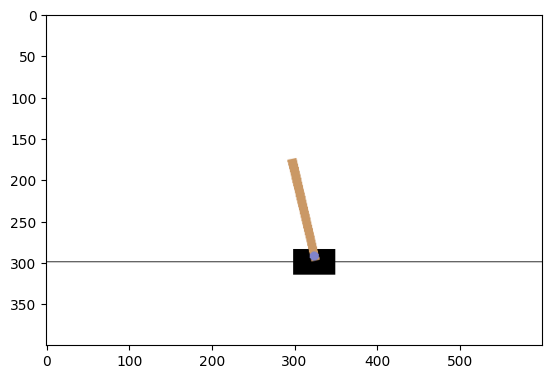

In [50]:
show_policy(cartpole, None, n_episodes=5, max_steps=500)

It in not possible to apply tabular reinforcement learning methods to this environment because the state space is continuous. We need to use function approximation in order to generalize.

## Fully Connected Q-function

The Neural Fitted Q ([M. Riedmiller, "Neural fitted Q iteration – first experiences with a data efficient neural reinforcement learning method", ECML (2005)](https://link.springer.com/chapter/10.1007/11564096_32)) is one of the first algorithms to successfully **use neural networks as a function approximation** to solve reinforcement learning problems. We refer to the approximate action-value function estimate as $Q(s,a; \theta)$, which means the $Q$ estimate is parameterized by $\theta$, the weights of a neural network, a state $s$ and an action $a$.

In order to design the function approximator, we can observe that the matrix holding the action-value function was indexed by state and action pairs, so a straightforward neural network architecture is to input the state and the action to evaluate, and output would then be one node representing the Q-value for that state-action pair:

<img src="./images/ann-nfq-1.png" width="600">

This architecture would work fine, but a more efficient architecture consists of **only inputting the state to the neural network and outputting the Q-values for all the actions**:
in that state.

<img src="./images/ann-nfq-2.png" width="600">

This is clearly advantageous when using exploration strategies such as epsilon-greedy or softmax, because **having to do only one pass forward to get the values of all actions** for any given state yields a high-performance implementation.

<img src="./images/nfq-agent.png" width="600">

We can implement the function approximator as a **fully Connected network** using a machine learning library, such as PyTorch. The network will have two hidden layers with some neurons each (e.g. for the cartpole case 512 and 128 neuron are eough) and a ReLU activation function. The output layer will have a linear activation function, because we want to output the Q-values directly. The input layer will have four neurons, one for each of the state variables. 

In [3]:
import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Approximator, self).__init__()

        # activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # input layer
        self.input_layer = torch.nn.Linear(state_size, 512)
        
        # chidden layer 
        self.hidden_layer = torch.nn.Linear(512, 128)

        # output layer    
        self.output_layer = torch.nn.Linear(128, action_size)

    def forward(self, state):
       
        # convert the state into a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass hidden layer
        x = self.activation(self.hidden_layer(x))

        # finally, pass for the output layer
        q_values = self.output_layer(x)
        
        return q_values

    def select_action(self, state):

        # convert the state into a tensor
        state = torch.FloatTensor(state).unsqueeze(0)

        # calculate q_values from the network
        q_values = self(state).detach()

        # act greedy
        action = np.argmax(q_values).data.numpy()
        
        return action

In [4]:
state_size = cartpole.observation_space.shape[0]
action_size = cartpole.action_space.n

approximator = Approximator(state_size, action_size)

In [5]:
print(approximator)

Approximator(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layer): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)


We need a buffer on which store collected experiences to be used as a batch for training the network:

In [6]:
class ExperienceBuffer():
    def __init__(self, state_shape, buffer_size):
        self.buffer_size = buffer_size
        
        # prepare the buffer for the experience
        self.states = np.empty(shape=(buffer_size, state_shape), dtype=np.float32)
        self.actions = np.empty(shape=(buffer_size), dtype=np.int8)
        self.rewards = np.empty(shape=(buffer_size), dtype=np.float32)
        self.next_states = np.empty(shape=(buffer_size, state_shape), dtype=np.float32)
        self.is_failures = np.empty(shape=(buffer_size), dtype=np.int8)

        # update index
        self.next_index = 0

    def store(self, state, action, reward, next_state, is_failure):

        # store the experience in the buffer
        self.states[self.next_index] = state
        self.actions[self.next_index] = action
        self.rewards[self.next_index] = reward
        self.next_states[self.next_index] = next_state
        self.is_failures[self.next_index] = is_failure

        # update index
        self.next_index += 1
    
    def get(self):
        # return experience
        return self.states, self.actions, self.rewards, self.next_states, self.is_failures

    def clear(self):
        # restart from the begging of the buffer
        self.next_index = 0

    def len(self):
        return self.next_index

## Optimization method

Gradient Descent (GD) is a stable optimization method given a couple of assumptions: data must be **independent and identically distributed (IID)** and targets must be **stationary**. In reinforcement learning we cannot ensure any of these assumptions. So choosing a robust optimization method (Batch Gradient Descent, Mini-batch Gradient Descent, Stochastic Gradient Descent, etc..) to minimize the loss function can often make the difference between convergence and divergence.

A classic optimization method in supervised learning is **batch gradient descent**, it takes the entire dataset at once, calculates the gradient of the dataset and steps toward this gradient a little bit at a time. Then, it repeats this cycle until convergence. When we have a considerable dataset with millions of samples, batch gradient descent is too slow to be practical. Moreover, in reinforcement learning, we don’t even have a dataset in advance, so batch gradient descent isn’t a practical method for our purpose.

<img src="./images/batch-gradient-descent.png" width="500">

An optimization method capable of handling smaller batches of data is called **mini-batch gradient descent**, where we use only a fraction of the data at a time. We can control the size of the mini-batches, which allows the processing of large datasets. At one extreme, we can set the size of mini-batch to the size of the dataset (batch gradient descent), at the other extreme, we can set the size to a single sample (**stochastic gradient descent**). The larger the batch, the lower the variance the steps of the optimization method have, but learning slows down considerably:

<img src="./images/mini-batch-gradient-descent.png" width="600">

An improved algorithm is called **gradient descent with momentum**. This is a mini-batch gradient descent that updates the network’s weights in the direction of the moving average of the gradients, instead of the gradient itself.

<img src="./images/momentum.png" width="600">

Similar to momentum is **root mean square propagation (RMSprop)**, it reduces oscillations by scaling the gradient in proportion to the average magnitude of recent gradients. A final optimization method is called **adaptive moment estimation (Adam)**, a combination of RMSprop and momentum: it steps in the direction of the velocity of the gradients (as momentum), but it scales updates in proportion to the moving average of the magnitude of the gradients (as RMSprop). 

In practice, both Adam and RMSprop are sensible choices for reinforcement learning. We add an optimizer to the agent:

In [7]:
optimizer = torch.optim.RMSprop(approximator.parameters(), lr=0.001)

## Loss function

The **loss function** is a measure of how well a neural network predictions are. In supervised learning, it’s straightforward to interpret: given a batch of predictions and their corresponding true values, the loss function computes a distance score indicating how well the network has done in this batch.

There are many different ways for calculating this distance score, one of the most common ones is MSE (**mean squared error**, or L2 loss). It is defined as the average squared difference between the "predicted" and "true" values. In our case, the "predicted values" are the values of the action-value function that come straight from the neural network. But the "true values"?

An ideal objective would be to calculate the loss with respect to the "true" (optimal) action-value function q*:

$\displaystyle L(\theta)=E_{s,a}[(q_*(s,a)-Q(s,a;\theta))^2] $

Obviously, we are not talking about having access to q* (otherwise, there’s no need for learning), but if we had **access to sampling of the optimal action-value function**, we could then minimize the loss between the approximate and optimal action-value functions.

Well, we don’t have sample of that optimal values (because we don’t have the optimal policy either), remember that  

$\displaystyle q_*(s,a) = \underset{\pi }{\text{max }} E_{\pi}(G_t|S_t=s, A_t=a) $

We can use the same principles learned in generalized policy iteration, in which we **alternate between policy-evaluation and policy-improvement processes** to find good policies. However, because we’re using non-linear function approximation, **convergence guarantees no longer exist**. 

In the NFQ implementation we do just that: we start with a randomly initialized action-value function (and implicit policy); then we evaluate the policy by sampling actions from it; then, we improve it with an exploration strategy (such as epsilon-greedy); and finally, keep iterating until we reach the desired performance.

So, **we use as "true values" the targets**, which depend on a prediction also coming from the network, the value of the next state, in a circular dependency:

<img src="./images/circular-dependency.png" width="600">

As you may be thinking, **this circular dependency is bad**. It’s not well behaved because it doesn’t respect several of the assumptions made in supervised learning problems.

There are different targets we can use for estimating the action-value function of a policy: Monte Carlo (MC) target, temporal-difference (TD) target, n-step target, and lambda target:

<img src="./images/targets.png" width="600">

Moreover, the TD target can be either on-policy (SARSA) or off-policy (Q-learning), depending on the way we bootstrap the target. The two main ways are to either use the action-value function of the action the agent will take at the landing state, or alternatively, to use the value of the action with the highest estimate at the next state:

$\displaystyle Q^\text{SARSA}(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha  [ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) ]$

$\displaystyle Q^\text{Q-learning}(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [ R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) - Q(S_t, A_t) ]$

In principle, the above Q-learning rule can be directly implemented in a neural network. Since no direct assignment of Q-values like in a table based representation can be made, instead, an error function is introduced, that aims to measure the difference between the current Q-value and the new value that should be assigned. For example, a squared-error measure like the following can be used:

$\displaystyle L(\theta)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta) - Q(s,a;\theta))^2 \right] $

Moreover, When differentiating through this equation, it’s important to notice that the gradient doesn’t involve the target, it must only go through the predicted value (this is one common source of error). In supervised learning, we have "predicted values" (that come from the learning model) and "true values" (commonly **constants** and provided in advance). In RL, the "true values" depend on predicted values themselves: they come from the model. For instance, when we form a TD target, we use a reward (which is a constant) and the discounted value of the next state (which comes from the model). This value is also not a "true value", and it comes from the neural network, however **it should be treated as a constant**.

$\displaystyle \nabla_{\theta_i} L(\theta)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta) - Q(s,a;\theta)) \nabla_{\theta} Q(s,a;\theta) \right] $

At this point, common gradient descent techniques (like the ’backpropagation’ learning rule) can be applied to adjust the weights of the neural network in order to minimize the error. This update rule is typically applied after each new sample. The problem with this on-line update rule is, that typically, several ten thousands of episodes have to be done until an optimal or near optimal policy has been found. One reason for this is, that if weights are adjusted for one certain state action pair, then unpredictable changes also occur at other places in the state-action space. Although in principle this could also have a positive effect (generalization) in many cases this seems to be the
main reason for unreliable and slow learning. The basic idea underlying NFQ is the following: instead of updating the neural value function on-line, the **update is performed off-line considering an entire set of transition experiences**. Experiences are collected in triples of the form (state, action, next_state) by interacting with the environment.

In [8]:
def optimize(experiences, model, optimizer, gamma, epochs):
    
    # get the experience
    states, actions, rewards, next_states, is_failures = experiences  

    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()

    for _ in range(epochs):

        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants 
        q_next = model(next_states).detach()
        
        # get the max value 
        max_q_next = q_next.max(1)[0].unsqueeze(1)

        # one important step, often overlooked, is to ensure 
        # that failure states are grounded to zero
        max_q_next *= (1 - is_failures)

        # calculate the target 
        target = rewards + gamma * max_q_next

        # finally, we get the current estimate of Q(s,a)
        q_current = torch.gather(model(states), 1, actions)

        # create the errors
        td_error = target - q_current

        # calculate the loss
        value_loss = td_error.pow(2).mean()

        # optimize the network
        optimizer.zero_grad()
        value_loss.backward()
        optimizer.step()

## Exploration strategy

We need to **decide how to balance the exploration-exploitation trade-off**: almost any technique would work fine. To keep things simple, we’re going to use an **epsilon-greedy strategy** on our implementation. Remember that the implication of the off-policy learning is that there are two policies: a policy that generates behavior (in this case is an epsilon-greedy policy) and a policy that we’re learning about (the greedy an ultimately optimal policy). Notice that the generating behavior can be virtually anything, as long as it has broad support: **must ensure enough exploration** of all state-action pairs. In our NFQ implementation, we will use an epsilon-greedy strategy that selects an action randomly half of the time during training.

In [9]:
import random

def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function. This means that we will always select the action that maximizes the action-value function, without any exploration. This is because we want to evaluate the agent’s performance, and not the exploration strategy.

In [10]:
def greedy(approximator, state):
    return approximator.select_action(state)

We need a function in order to evaluate the performance of our agent. We will use the average reward over a number of episodes as our metric.

In [11]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

## Full Algorithm

Now we can put things together: 

- use a fully connected neural network with states as input and actions as output; 
- use an epsilon-greedy strategy to explore the environment;
- use the off-policy TD targets to improve the action-value function
- use mean squared error (MSE) for the loss function; 
- use Adam as optimizer.

The full neural fitted Q-iteration (NFQ) algorithm has three main steps:

1. collect some experiences (e.g. 1024 samples)
2. calculate the off-policy TD targets
3. fit the action-value function using MSE and RMSprop
4. repeats steps 2 and 3 a number of times before going back to step 1

<img src="./images/nfq.png" width="600">

We create a method to manage this process:

In [12]:
import time
import numpy as np
import random
from itertools import count

def nfq(env_name, seed, 
        batch_size, epochs, gamma, epsilon, learning_rate,
        max_episodes, max_time, max_score, episodes_window):

    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_shape = env.observation_space.shape[0]
    action_size = env.action_space.n

    # create the experience buffer 
    experience_buffer = ExperienceBuffer(state_shape, batch_size) 

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the neural models
    model = Approximator(state_size, action_size)

    # create the optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []  

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan

    # train until we reach a terminal condition
    for episode in count():
    
        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0

        # reset the environment at the beginning of the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for episode_step in count():
                
            # select the action using the exploration policy
            action = epsilon_greedy(model, state, action_size, epsilon)
            
            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience
            experience_buffer.store(state, action, reward, next_state, is_failure)

            # if the experience collected so far is enough, optimize the model 
            # and clear the buffer
            if experience_buffer.len() == batch_size:
                optimize(experience_buffer.get(), model, optimizer, gamma, epochs)
                experience_buffer.clear()
        
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward

            # update the total steps
            total_step += 1
        
            if is_done:
                break

        # evaluate the learned policy after the episode
        score = evaluate(model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(episode_step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        training_time += episode_elapsed   
    
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, total steps {:06}, score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached max episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached max time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached max score ')
            break

    return model, score, results

We can apply the NFQ algorithm to the Cart-pole environment:

In [14]:
def run_experiment(env_name, seeds,
                   batch_size, epochs, gamma, epsilon, learning_rate,
                   max_episodes, max_time, max_score, episodes_window):

    # variables to collect results
    results = []
    best_agent = None
    best_eval_score = float('-inf')
    
    for seed in seeds:
        # create the agent
        agent, score, result = nfq(env_name, seed, 
                                   batch_size, epochs, gamma, epsilon, learning_rate,
                                   max_episodes, max_time, max_score, episodes_window)

        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent
        
    return results, best_agent, best_eval_score

In [15]:
nfq_results, nfq_agent, nfq_score = run_experiment(
    env_name='CartPole-v1', 
    seeds = (12, 34, 56, 78, 90),
    batch_size = 1024,
    epochs = 40,
    gamma = 0.99,
    epsilon = 0.5,
    learning_rate = 0.0005, 
    max_episodes = 3000,
    max_time = 4*60,
    max_score = 450,
    episodes_window = 50)

episode 0931, total steps 050106, score 450.3  --> reached max score 
episode 1672, total steps 123937, score 453.3  --> reached max score 
episode 0986, total steps 051125, score 450.0  --> reached max score 
episode 0850, total steps 061692, score 451.2  --> reached max score 
episode 0993, total steps 061916, score 450.2  --> reached max score 


NFQ is not a state-of-the-art solution, however in a somewhat simple environment as the cartpole, it shows a decent performance:

In [16]:
nfq_max_steps, nfq_max_train_reward, nfq_max_eval_score, nfq_max_time = np.max(nfq_results, axis=0).T
nfq_min_steps, nfq_min_train_reward, nfq_min_eval_score, nfq_min_time = np.min(nfq_results, axis=0).T
nfq_mean_steps, nfq_mean_train_reward, nfq_mean_eval_score, nfq_mean_time = np.mean(nfq_results, axis=0).T
nfq_episodes = np.arange(len(nfq_mean_steps))

We can save results on a file to compare with other algorithms in future lectures:

In [17]:
np.save('../models/nfq_results', nfq_results)

We can plot the training reward. Notice that the it never reaches the max of 500 reward per episode. The reason is we are using an epsilon of 0.5. Having such a high exploration rate helps with finding more accurate value functions, but it shows worse performance during training. 

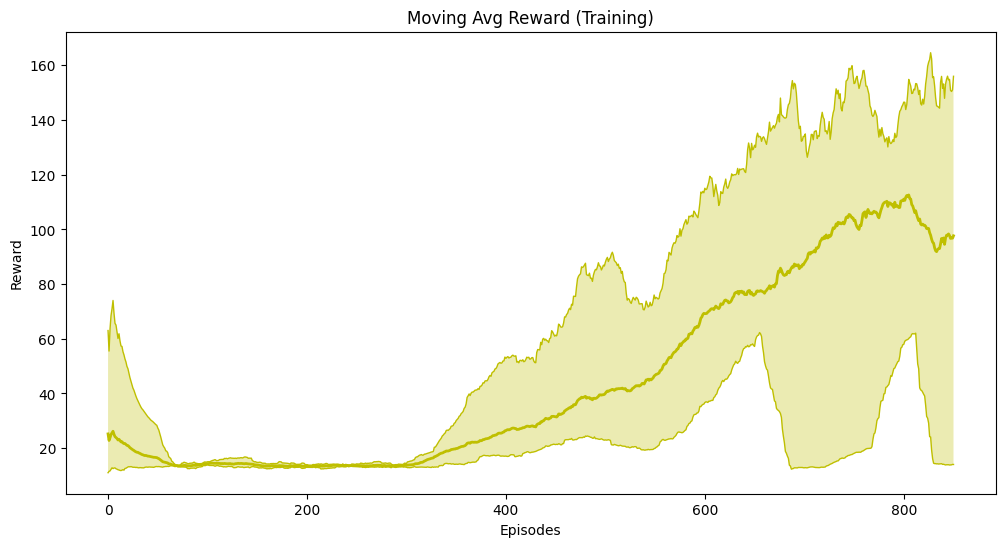

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.show()

Plotting the reward during evaluation steps shows the best performance we can obtain from the agent. Notice that the reward is not stable, it fluctuates a lot.     

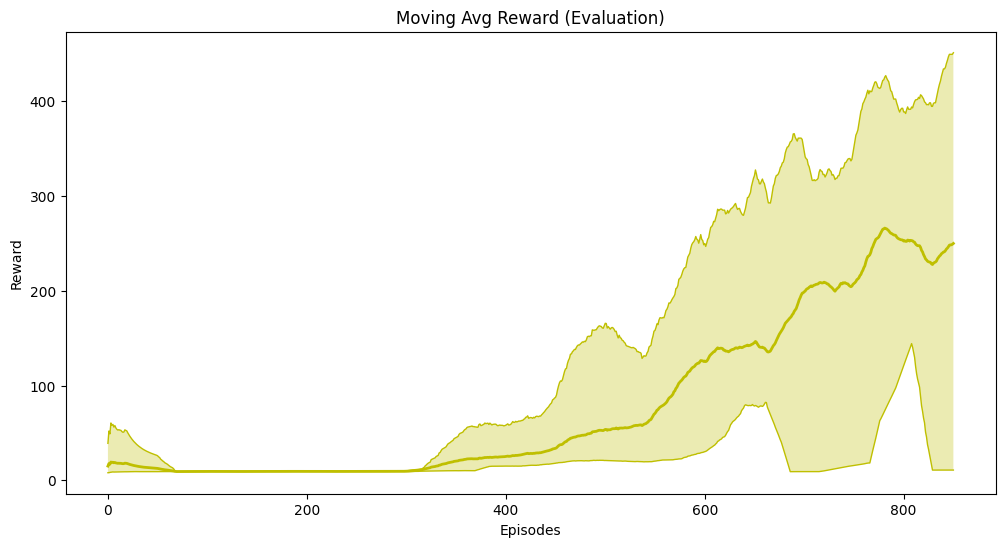

In [19]:
plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.show()

Plotting the total steps per episode shows that the agent is learning something, but it is not learning fast enough. The main issue with NFQ is that it takes too many steps to get decent performance. In other words, in terms of sample efficiency, NFQ does poorly.

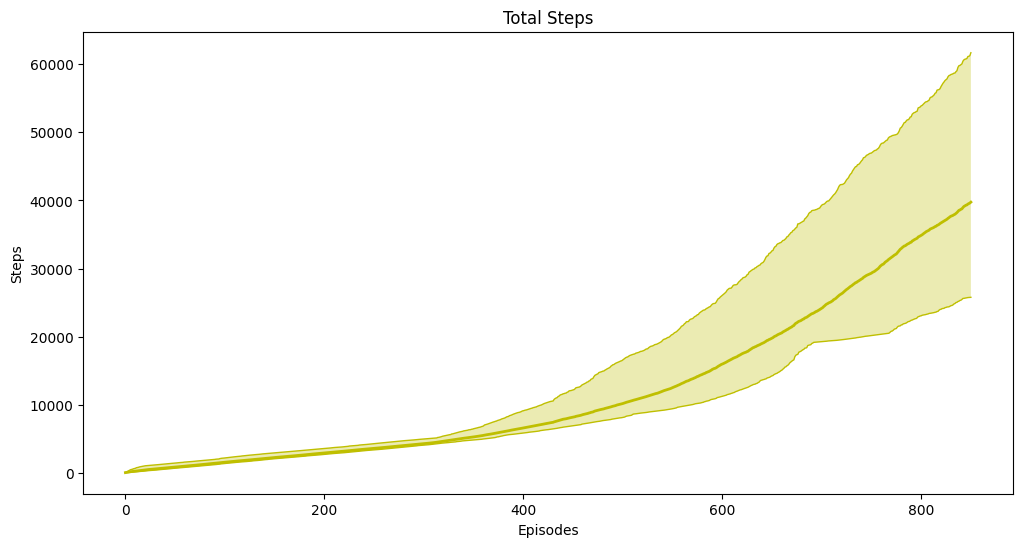

In [20]:
plt.figure(figsize=(12,6))

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')

plt.plot(nfq_max_steps, 'y', linewidth=1)
plt.plot(nfq_min_steps, 'y', linewidth=1)
plt.plot(nfq_mean_steps, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_steps, nfq_max_steps, facecolor='y', alpha=0.3)

plt.show()

The next plot is related to time. We can see how NFQ takes approximately several seconds on average to pass the environment.

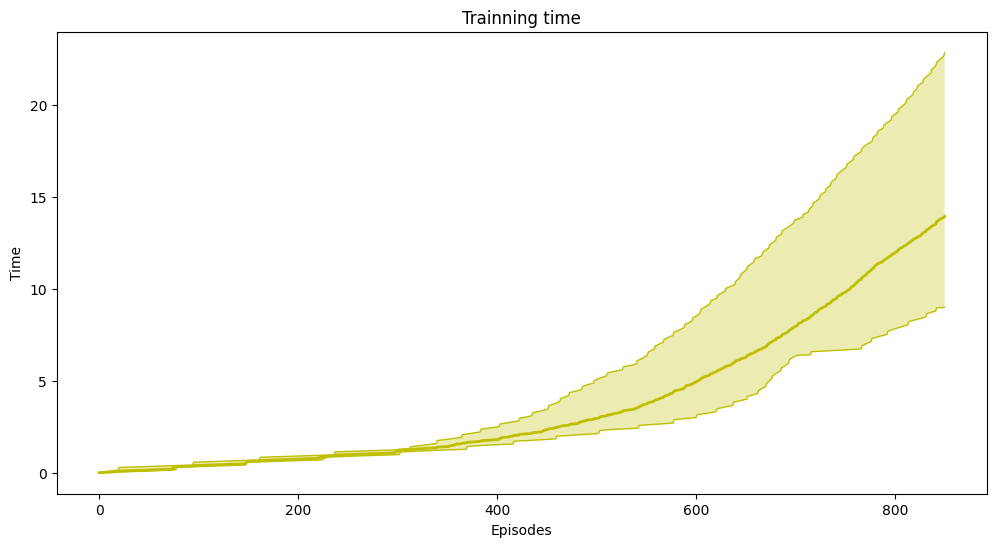

In [21]:
plt.figure(figsize=(12,6))

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.show()

We can display the trained model behavior:

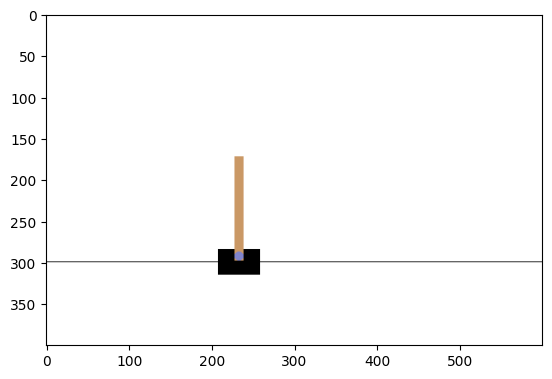

In [22]:
show_policy(cartpole, nfq_agent, n_episodes=1, max_steps=500)

## Challenges

There are two issues with NFQ algorithm. First, we’re using a powerful function approximator, that can generalize across state-action pairs, which is excellent, but that also means that the neural network adjusts the values of all similar states at once. However, notice that **our target values depend on the values for the next state**. In other words, we’re creating a **non-stationary target** for our learning updates. As we update the weights of the approximate Q-function, the targets also move and make our most recent update outdated. Thus, training becomes **unstable** quickly.

<img src="./images/non-stationary-target.png" width="500">

The way NFQ addresses the issue is through the use of **batching**. By growing a batch, we have the opportunity of optimizing several samples at the same time. The larger the batch, the more the opportunity for collecting a diverse set of experience samples. 

Second, we batched experience samples, collected online, and update the neural network from that mini-batch. However, these samples are **correlated**, they come from the same trajectory and policy. That means the network learns from mini-batches of samples that are similar, and later uses different mini-batches that are also internally correlated, but likely different from previous mini-batches. All this means that **we aren’t holding the IID assumption**, and this is a problem because optimization methods assume the data samples they use for training are independent and identically distributed. But we’re training on almost the exact opposite: **samples are not independent** (the outcome of a new state is dependent on
current state s); and, **samples aren’t identically distributed** (underlying data generating process, the policy, is changing over time). Optimization methods allow us to relax the IID assumption to a certain degree, but reinforcement learning problems go all the way, so we need to do something about this, too.


